In [1]:
%run "./000_RunImports.ipynb"

SAMPLES_TO_MS = 1000. / 50000.
MS_TO_SAMPLES = 1. / SAMPLES_TO_MS

In [2]:
# %run "./001_GenerateData.ipynb"
# %run "./002_PickleZipData.ipynb"

In [3]:
%run "./003_RestoreDatasFromPickle.ipynb"

In [4]:
%run scripts/analysis/analysis.py
%run scripts/analysis/spike_results.py
%run scripts/time_constants.py

In [5]:
costim_blue = (0, 0.43, 0.86)

In [6]:
runs = list(y for x in datas for y in x.runs)

In [7]:
# put into buckets
for x in runs:
    x.opt_bucket = Analysis.bucket(x.opt_thresh, 5)
    x.elec_bucket = Analysis.bucket(x.elec_thresh, 10)

> **Consider AP firing probability with the following conditions:**
> - Initial voltage within +/- ALLOWED_DELTA (4 by default) of holding voltage
> - Offset < 30ms
> - No electrical- or optical-only APs
> - Opt thresh > 0

In [8]:
HOLD = -61 # holding excluding junction potential
HOLD_JNC = HOLD + (1000 * d.JNC_POT) # holding including junction potential
ALLOWED_DELTA = 4

In [9]:
print(f"Overall {len(runs)} runs were imported")
total_cells = np.unique([x.cell for x in runs])
print(f"--> There were {len(total_cells)} cells")
print(f"--> The cells were {total_cells}")

Overall 3259 runs were imported
--> There were 14 cells
--> The cells were [4404 4405 4504 4801 4803 4806 4904 5006 5205 5207 5504 6703 6708 6709]


In [10]:
# data suitable for single spike costimulation analysis
# - correct holding voltage, 
# - no opt/elec standalone APs on the run,
# - 0-100% exclusive powers
selected_data = [
    run for run in runs if Analysis.costim_selector(
        run,
        HOLD_JNC - ALLOWED_DELTA,
        HOLD_JNC + ALLOWED_DELTA
    )]

# data with a good holding voltage and optical power between 0 and 150%
valid_data = [
    run for run in runs if Analysis.valid_data_selector(
        run,
        HOLD_JNC - ALLOWED_DELTA,
        HOLD_JNC + ALLOWED_DELTA
    )]

selected_cells = len(set([x.cell for x in selected_data]))

costim_aps = [x for x in selected_data if x.costim_aps == 1]
costim_cells = len(set([x.cell for x in costim_aps]))

print(f"Selected {len(selected_data)} runs out of {len(runs)}")
print(f"Selected {selected_cells} cells, {costim_cells} with costim APs")
print(f"--> Of these runs {len(costim_aps)} or {100. * len(costim_aps) / len(selected_data):.0f}% had costim APs")
print(f"--> Selected cells include {np.unique([x.cell for x in selected_data])}")
print(f"--> Excluded cells were {[x for x in total_cells if x not in [x.cell for x in selected_data]]}")

Selected 1053 runs out of 3259
Selected 9 cells, 7 with costim APs
--> Of these runs 451 or 43% had costim APs
--> Selected cells include [4405 4504 4801 4803 4904 5504 6703 6708 6709]
--> Excluded cells were [4404, 4806, 5006, 5205, 5207]


In [11]:
spikes = SpikeResults.get_spikes(selected_data) # use selected_data not costim_aps as we want no APs too
spike_dict = { 'Optical' : [], 'Electrical': [], 'Offset': [], 'Costim': [] }

for opt in spikes.keys():
    for elec in spikes[opt].keys():
        for off in spikes[opt][elec].keys():
            dat = spikes[opt][elec][off]
            spike_dict['Optical'].append(opt)
            spike_dict['Electrical'].append(elec)
            spike_dict['Offset'].append(off)
            spike_dict['Costim'].append(dat.costim())

spike_df = pd.DataFrame(spike_dict)
spike_df_metrics = spike_df.groupby(['Offset'])['Costim'].agg([np.mean, stats.sem]).dropna().reset_index()


# find points above the costimulation threshold (only consider points with offset >= 0, otherwise this isn't costim)
firing_avg_df = spike_df[spike_df['Offset'] >= 0].groupby(['Optical', 'Electrical'])['Costim'].agg(np.mean).reset_index()
firing_avg_above_50_df = firing_avg_df[firing_avg_df['Costim'] > 50.]
above_threshold_parameters = [tuple(x) for x in firing_avg_above_50_df[['Optical', 'Electrical']].values]

D:\Tools\Anaconda\lib\site-packages\numpy\core\_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
D:\Tools\Anaconda\lib\site-packages\numpy\core\_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [12]:
# Get average optical threshold value
opt_thresh = [x[d.C_OPT] for x in CELLS if x[1] > 1750] # constraint to above nonzero linear region due to power meter restrictions
elec_thresh = [x[d.C_ELC] for x in CELLS]
mean_laser_thresh = np.mean(opt_thresh)
mean_laser_thresh_sem = stats.sem(opt_thresh)
print(f"Mean optical threshold {mean_laser_thresh:.0f}, +/- SEM {mean_laser_thresh_sem:.0f}")

# Find the equivalent mW values from the laser calibration curve
dacs = [
    1650, 1700, 1750, 1800, 1850, 1900, 1950, 2000, 2050, 2100, 2150, 2200, 2250,
    2300, 2350, 2400, 2450, 2500, 2550, 2600, 2650, 2750, 3000, 3500, 4000
]
powers = [
    0, 0, 0, 2, 4, 6, 8, 10, 12, 14, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 32, 36, 42, 48, 52
]

mean_laser_mW = np.interp(mean_laser_thresh, dacs, powers)
mean_laser_mW_semrange = 0.5 * (
    np.interp(mean_laser_thresh + mean_laser_thresh_sem, dacs, powers) - np.interp(mean_laser_thresh - mean_laser_thresh_sem, dacs, powers)
)
print(f"Mean laser power {mean_laser_mW:.1f} +/- {mean_laser_mW_semrange:.1f} mW (SEM)")

mean_elec_pA = np.mean(elec_thresh)
mean_elec_sem = stats.sem(elec_thresh)
print(f"Mean electrical threshold {mean_elec_pA:.0f} +/- {mean_elec_sem:.0f} pA (SEM)")

## Due to power meter restrictions at lower irradiance, +/- is a more accurate representation
# opts_above = [x for x in opt_thresh if x > 1750]
# print(opts_above)
# print(f"Laser Power {np.min(opts_above)}-{np.max(opts_above)}")
# print(f"Laser Power {np.interp(np.min(opts_above), dacs, powers)}-{np.interp(np.max(opts_above), dacs, powers)}")

Mean optical threshold 2008, +/- SEM 85
Mean laser power 10.3 +/- 3.4 mW (SEM)
Mean electrical threshold 176 +/- 13 pA (SEM)


## Analysis of thresholds

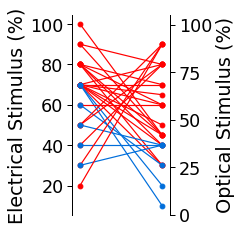

In [13]:
E = [x.elec_bucket for x in costim_aps]
O = [x.opt_bucket for x in costim_aps]
EO = np.unique(list(zip(E, O)), axis=0)

fix, (ax) = plt.subplots(1, 1, figsize=(GRID_SIZE, GRID_SIZE))

for (e, o) in reversed(EO):
    col = costim_blue if e + o < 100 else 'r'
    ax.plot([0, 1], [e, o], color=col, marker='o')
    
ax2 = ax.twinx()
sns.despine(right=False, top=True, bottom=True)
plt.xlim((-0.1, 1.1))
plt.ylim((0, 105))

ax.set_ylabel('Electrical Stimulus (%)')
ax2.set_ylabel('Optical Stimulus (%)')
# plt.xticks([0, 1], ['Electrical', 'Optical'])
plt.xticks([-100, 100])

plt.tight_layout()
plt.show()

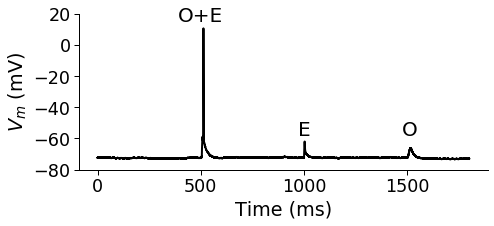

Opt bucket: 90, elec bucket: 50
--> from 67_Data 110.axgd offset 5ms


In [14]:
# First plot a representative shape
costim_example_idx = 1046 # 229
opt_pt = 1500

plt.figure(figsize=(2*GRID_SIZE, GRID_SIZE))

selected_data[costim_example_idx].plot(color='k', lw=2)

plt.text(500, 15, "O+E", ha='center', fontsize=20)
plt.text(opt_pt + 12, -58, "O", ha='center', fontsize=20)
plt.text(1000, -58, "E", ha='center', fontsize=20)

plt.tight_layout()
plt.ylabel('$V_m$ (mV)')
plt.yticks([-80, -60, -40, -20, 0, 20])

sns.despine()
plt.show()

print(f"Opt bucket: {selected_data[costim_example_idx].opt_bucket}, elec bucket: {selected_data[costim_example_idx].elec_bucket}")
print(f"--> from {selected_data[costim_example_idx].file_data._meta[0]} offset {selected_data[costim_example_idx].offset}ms")

### Example spikes

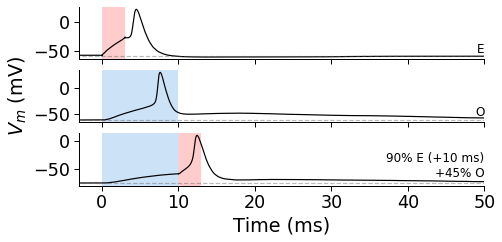

In [15]:
fig, (axE, axO, axOE) = plt.subplots(3, 1, figsize=(2*GRID_SIZE, GRID_SIZE), sharex=True)

sig_length = int(60 * MS_TO_SAMPLES)
warmup = int(5 * MS_TO_SAMPLES)
costim_start = 25000
elec_start = 20000
opt_start = 40000

t = np.arange(0, (sig_length + warmup) * SAMPLES_TO_MS, SAMPLES_TO_MS) - 5

# plot costim
costim_idx_ = 48   # another good example of a regular AP
costim_run = costim_aps[costim_idx_]
costim_ = costim_run.data
axOE.plot(t, costim_[costim_start-warmup:costim_start+sig_length] * 1000, color='k')
axOE.plot([-100, 100], [1000 * np.mean(costim_[:100]), 1000 * np.mean(costim_[:100])], color='#555555', alpha=0.4, linestyle='--')

# plot electrical - pick random ELEC_ONLY file
elec_idx = 10
axo = axographio.read(os.path.join(d.BASE_PATH, ELEC_ONLY_FILES[elec_idx][0]))
elec_ = axo.data[29]
axE.plot(t, elec_[elec_start-warmup:elec_start+sig_length] * 1000, color='k')
axE.plot([-100, 100], [1000 * np.mean(elec_[:100]), 1000 * np.mean(elec_[:100])], color='#555555', alpha=0.4, linestyle='--')

# plot optical
opt_idx = 11
axo = axographio.read(os.path.join(d.BASE_PATH, OPT_ONLY_FILES[opt_idx][0]))
opt_ = axo.data[10]
axO.plot(t, opt_[opt_start-warmup:opt_start+sig_length] * 1000, color='k')
axO.plot([-100, 100], [1000 * np.mean(opt_[:100]), 1000 * np.mean(opt_[:100])], color='#555555', alpha=0.4, linestyle='--')

# show stimulus
axO.axvspan(0, 10, facecolor=costim_blue, alpha=0.2, label='Laser')
axE.axvspan(0, 3, facecolor='r', alpha=0.2, label='Current')
axOE.axvspan(0, 10, facecolor=costim_blue, alpha=0.2, label='Laser')
axOE.axvspan(costim_run.offset, costim_run.offset + 3, facecolor='r', alpha=0.2, label='Electrical')

# label graphs
fontsize=12
axO.text(50, -54, 'O', ha='right', fontsize=fontsize)
axE.text(50, -54, 'E', ha='right', fontsize=fontsize)
axOE.text(50, -65, f'{costim_run.elec_bucket}% E (+{costim_run.offset} ms)\n+{costim_run.opt_bucket}% O', ha='right', fontsize=fontsize)

# format
# axE.legend(loc=5)
sns.despine()
axO.set_ylabel('$V_m$ (mV)')
plt.xlabel('Time (ms)')
plt.tight_layout()
plt.xlim((-3, 50))
plt.subplots_adjust(wspace=0, hspace=0.2)

plt.show()

In [16]:
def plot_standalone_ap(data, show_scale, label, ax=None, xstart=475, ystart=-65, **kwargs):
    if ax is None:
        fig, (ax) = plt.subplots(1, 1, figsize=(12,3))
    
    yhat = data * 1000
    
#     yhat = savgol_filter(data * 1000, 31, 3)

#     nyq = 0.5 * 50000
#     low = 10 / nyq
#     high = 10000 / nyq
#     b, a = butter(2, [low, high], btype='band')    
#     yhat = lfilter(b, a, data * 1000)
    
    ax.plot([i * SAMPLES_TO_MS for i, x in enumerate(yhat)], yhat, color='k', lw=1)
    
    if show_scale:
        draw_bars(ax, 10, "10 ms", 20, "20 mV", **kwargs)

    ax.axhline(np.mean(yhat[0:50]), linestyle='--', color='k', alpha=0.4, lw=1)
    
    ax.text(xstart + 150, ystart + 8, label, ha='right', va='bottom')
    
    ax.axis('off')
    ax.set_xlim((xstart, xstart + 150))
    ax.set_ylim((ystart, ystart + 125))

In [17]:
def draw_spike(ax, times, data, offset, ms_offset):
    ax.plot(times, [x + offset for x in data], lw=2, color='k', alpha=0.8)
    ax.text(0.48, data[0] + offset, f"{ms_offset} ms", fontsize=12, va='bottom', ha='left')
    start = np.mean(data[:500]) + offset
    ax.plot([min(times), max(times)], [start, start], lw='1', color='#777777', alpha=0.6)
    ax.hlines(start-12, 0.5 + ms_offset/1000, 0.503 + ms_offset/1000, color='r', lw=7, alpha=0.7)

def draw_scalebar(ax, x, y, fs=12):
    # draw a scale bar
    dx = 0.01
    dy = 50
    lw=2
    ax.plot([x, x+dx], [y, y], color='k', lw=lw)
    ax.plot([x, x], [y, y+dy], color='k', lw=lw)
    ax.text(x+dx+0.001, y-4, "10 ms", ha='left', fontsize=fs)
    ax.text(x-0.006, y+dy+10, "50 mV", ha='left', fontsize=fs)
            
def plot_stacked_spikes(data, num=18, start_idx=0, stride=4, width=GRID_SIZE, scalebar=True, offset=35, ax=None):
    if ax is None:
        fig, (ax) = plt.subplots(1, 1, figsize=(width, width))
    else: 
        fig = None
    
    ax.axvspan(0.5, 0.51, facecolor=costim_blue, alpha=0.2)

    for i in range(start_idx, num, stride):
        draw_spike(ax, data.times, [x * 1000 for x in data.runs[i].data], (num - i) * offset, data.runs[i].offset)

    ax.set_frame_on(False)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlim((0.48, 0.57))
    ax.set_ylim((-offset, offset * num))
    
    if scalebar:
        draw_scalebar(ax, 0.55, offset * (num - 1.2))
    
    plt.tight_layout()
    
    return (fig, ax)

In [18]:
# [(40, 40), (40, 50), (40, 70), (40, 80), (45, 80), (45, 100), (60, 60), (60, 70), (60, 80), (65, 70), (70, 80), (80, 90)]
(o, e) = (40, 40)
data_1d = next(x.file_data for x in selected_data if x.opt_bucket == o and x.elec_bucket == e)

In [19]:
# [(40, 40), (40, 50), (40, 70), (40, 80), (45, 80), (45, 100), (60, 60), (60, 70), (60, 80), (65, 70), (70, 80), (80, 90)]
(o, e) = (45, 80)
data_1e = next(x.file_data for x in selected_data if x.opt_bucket == o and x.elec_bucket == e)

In [20]:
(o, e) = (65, 70)
data_1f = next(x.file_data for x in selected_data if x.opt_bucket == o and x.elec_bucket == e)

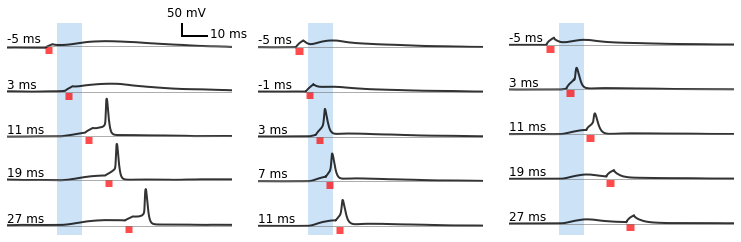

In [21]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(3 * GRID_SIZE, GRID_SIZE))
plot_stacked_spikes(data_1d, ax=ax1)
plot_stacked_spikes(data_1e, scalebar=False, ax=ax2)
plot_stacked_spikes(data_1f, scalebar=False, ax=ax3)

plt.tight_layout()

In [22]:
# subthreshold optical stimulus
subthresh_opt = [
    run for run in runs if Analysis.subthresh_opt_selector(
        run,
        HOLD_JNC - ALLOWED_DELTA,
        HOLD_JNC + ALLOWED_DELTA
    )]

times = np.array(range(0, 20500)) * (1000. / 50000.) - 100
mean_optical = np.mean([x.opt_data[0:18000] * 1000 for x in subthresh_opt], axis=0)
std_optical = stats.sem([x.opt_data[0:18000] * 1000 for x in subthresh_opt], axis=0)

In [23]:
# import and analyse electrical only files
elec_only = []
elec_only_cells = set()

for filemeta in ELEC_ONLY_FILES:
    axo = axographio.read(os.path.join(d.BASE_PATH, filemeta[0]))
    elec_only_cells.add(filemeta[4])
    for idx in range(1, len(axo.names), 2):
        initial = np.mean(axo.data[idx][:1000])
        if initial < -0.07 or initial > -0.05:
            continue

        dat = np.array([x + d.JNC_POT for x in axo.data[idx][19500:21500]])
        if np.max(axo.data[idx]) > 0:
#             plt.plot(dat)
            peaks = TimeConstants.describe_peaks(dat, None, 0.02)
            if len(peaks) != 1:
                continue

            elec_only.append({
                "path": filemeta[0],
                "peaks": peaks[0],
                "data": dat,
                "vrest": np.mean(dat[0:200]),
                "max": np.max(dat),
                "tc": TimeConstants(peaks[0], axo.data[0][1] - axo.data[0][0], 500)
            })

In [24]:
"""

Build up suprathreshold and subthreshold numbers. Based on:
 - valid_data for costim,
 - OPT_ONLY_FILES for optical
 - ELEC_THRESHOLD_FILES for electrical

PLOTS ARE:
 - tau_on, tau_off

CONDITIONS ARE: 
 - sub_opt, sup_opt, sub_elec, sup_elec
"""

# First build up the conditions from selected data
df_data = []

def to_item(label, on_tau, off_tau, amp, width_at_0_mV, dvdt_avg: None):
    return { 'type': label, 'tau_on': on_tau, 'tau_off': off_tau, 'amplitude': amp, 'width': width_at_0_mV, 'dvdt_avg': dvdt_avg }

costim_cells = set()
opt_cells = set()
elec_cells = set()
all_elec_costim_cells = set()

# get electrical and optical AP data from the costim files
for x in costim_aps:
    df_data.append(
        to_item('costim', 
            float(x.costim_time_constants.on_tau.magnitude),
            float(x.costim_time_constants.off_tau.magnitude),
            x.costim_max.magnitude - x.v_rest,
            float(x.costim_time_constants.mv0_duration.magnitude),
            0 if x.costim_time_constants.derivative is None else x.costim_time_constants.derivative.dvdt_avg
       ))
    costim_cells.add(x.cell)
print(f"There are {len(costim_cells)} costim cells, {costim_cells}")

for f in OPT_ONLY_FILES:
    axo = axographio.read(os.path.join(d.BASE_PATH, f[0]))
    for raw in axo.data[1::3]:
        peaks = TimeConstants.describe_peaks(raw[39000 : 50000])
        if len(peaks) == 0:
            continue
        tcs = TimeConstants(peaks[0], SAMPLES_TO_MS / 1000, 1000)
        diffs = TimeConstants.get_derivative(raw[39000 : 50000], 2e-5 * q.second, 30, SAMPLES_TO_MS)
        t = 'sup_o' if raw[39000 : 50000][peaks[0]['peak']] > -0.02 else 'sub_o'
        df_data.append(to_item(
            t,
            tcs.on_tau,
            tcs.off_tau,
            peaks[0]['max'] * 1000,
            peaks[0]['0mv_duration'] * SAMPLES_TO_MS,
            0 if diffs is None else diffs.dvdt_avg
        ))
        opt_cells.add(f[1])
print(f"There are {len(opt_cells)} opt cells, {opt_cells}")

for f in ELEC_ONLY_FILES:
    axo = axographio.read(os.path.join(d.BASE_PATH, f[0]))
    for raw in axo.data[1::2]:
        initial = np.mean(raw[:1000])

        if initial < -0.07 or initial > -0.05:
            continue
            
        peaks = TimeConstants.describe_peaks(raw[19000 : 25000])
        if len(peaks) == 0:
            continue
        tcs = TimeConstants(peaks[0], SAMPLES_TO_MS / 1000, 1000)
        diffs = TimeConstants.get_derivative(raw[19000 : 25000], 2e-5 * q.second, 30, SAMPLES_TO_MS)
        t = 'sup_e' if raw[19000 : 25000][peaks[0]['peak']] > -0.02 else 'sub_e'
        df_data.append(to_item(
            t,
            tcs.on_tau,
            tcs.off_tau,
            peaks[0]['max'] * 1000,
            peaks[0]['0mv_duration'] * SAMPLES_TO_MS,
            0 if diffs is None else diffs.dvdt_avg
        ))
    elec_cells.add(f[4])
    
print(f"There are {len(elec_cells)} elec cells, {elec_cells}")

for f in FAKE_COSTIM_FILES:  
    axo = axographio.read(os.path.join(d.BASE_PATH, f[0]))
    for raw in axo.data[1::3]:
        initial = np.mean(raw[:1000])

        # only take values with relatively sane holding potential
        if initial < -0.07 or initial > -0.05:
            continue

        # only take APs
        if np.max(raw[24000 : 35000]) < -0.02:
            continue

        peaks = TimeConstants.describe_peaks(raw[24000 : 35000])
        # ignore where there aren't any peaks, or we detect more than one - this is suspect data
        if len(peaks) != 1:
            continue

        tcs = TimeConstants(peaks[0], SAMPLES_TO_MS / 1000, 1000)
        diffs = TimeConstants.get_derivative(raw[24000 : 35000], 2e-5 * q.second, 30, SAMPLES_TO_MS)
        df_data.append(to_item(
            'all_elec',
            tcs.on_tau,
            tcs.off_tau,
            peaks[0]['max'] * 1000,
            peaks[0]['0mv_duration'] * SAMPLES_TO_MS,
            0 if diffs is None else diffs.dvdt_avg
        ))
    all_elec_costim_cells.add(f[1])

print(f"There are {len(all_elec_costim_cells)} all elec costim cells, {all_elec_costim_cells}")
        
# df_data
time_constant_raw_df = pd.DataFrame(df_data)
time_constant_df = time_constant_raw_df.groupby(['type']).agg([np.mean, stats.sem])

# dvdt_avg for optical contains some 0 dv/dt averages. Can't include the mean / sem numbers
# these are excluded in the calculation below
time_constant_df[['amplitude', 'tau_off', 'tau_on', 'width']]

There are 7 costim cells, {4801, 4904, 6703, 6708, 4405, 6709, 4504}
There are 21 opt cells, {5003, 5006, 5007, 4502, 4504, 4903, 4904, 4403, 4404, 4405, 4801, 4803, 4804, 4805, 4806, 5202, 5203, 5204, 5205, 5207, 5208}
There are 11 elec cells, {4801, 4803, 4804, 4805, 4806, 5003, 5006, 4404, 4405, 4501, 4504}
There are 7 all elec costim cells, {5003, 5006, 5205, 5207, 5208, 5404, 5406}


amplitude              tau_off               tau_on            \
                mean       sem       mean       sem       mean       sem   
type                                                                       
all_elec   72.562504  0.601387   1.809143  0.025405  18.575117  0.257186   
costim    105.620343  0.623289   1.216940  0.055642   4.453171  0.327768   
sub_e      12.961865  0.352176   9.994619  0.310753   2.024395  0.183379   
sub_o      12.519569  0.530507  24.021939  0.808920  11.650182  1.596437   
sup_e     100.225683  1.389917   1.363017  0.026935   3.895531  0.124951   
sup_o      87.098994  1.504125   1.634506  0.028491  10.553391  0.386770   

             width                
              mean           sem  
type                              
all_elec  1.025974  2.512860e-02  
costim    0.873481  9.113133e-03  
sub_e     0.040000  3.289351e-19  
sub_o     0.040000  0.000000e+00  
sup_e     1.285028  1.935878e-02  
sup_o     1.194850  3.538082e-02

In [25]:
df_sig = pd.DataFrame(df_data)
costim = df_sig[df_sig['type'] == 'costim']
len(np.concatenate((costim['amplitude'].values, costim['amplitude'].values), axis=0))

902

In [26]:
def generate_pairwise(c, e, o, ee):
    return (
        np.concatenate((c.values, e.values, o.values, ee.values), axis=0),
        ['costim'] * len(c) + ['elec'] * len(e) + ['opt'] * len(o) + ['e+e'] * len(ee)
    )

def oneway_anova(column, c, e, o, ee):
    print(f"\n\n*** ANOVA ({column}) ***")
    f_mean, p_mean = stats.f_oneway(c[column], e[column], o[column], ee[column])
    print(f"One way ANOVA f: {f_mean:.2f}, p: {p_mean:.4f}")
    if p_mean < 0.05:
        dat, cat = generate_pairwise(c[column], e[column], o[column], ee[column])
        res = pairwise_tukeyhsd(dat, cat)
        print(res)
        p_vals = psturng(np.abs(res.meandiffs / res.std_pairs), len(res.groupsunique), res.df_total)
        print(f"p-values: {p_vals}")

print("*** SIGNIFICANCES (sub vs supra) ***")

def calc_sigs(data):
    esub = data[data['type'] == 'sub_e']
    esup = data[data['type'] == 'sup_e']
    osub = data[data['type'] == 'sub_o']
    osup = data[data['type'] == 'sup_o']
    costim = data[data['type'] == 'costim']
    allelec = data[data['type'] == 'all_elec']

    e_on_tt = stats.ttest_ind(esub['tau_on'], esup['tau_on'])
    print(f"E_tau_on: {e_on_tt.statistic:.2f}, p: {e_on_tt.pvalue:.4f}")

    e_off_tt = stats.ttest_ind(esub['tau_off'], esup['tau_off'])
    print(f"E_tau_off: {e_off_tt.statistic:.2f}, p: {e_off_tt.pvalue:.4f}")
    o_on_tt = stats.ttest_ind(osub['tau_on'], osup['tau_on'])
    print(f"O_tau_on: {o_on_tt.statistic:.2f}, p: {o_on_tt.pvalue:.4f}")

    o_off_tt = stats.ttest_ind(osub['tau_off'], osup['tau_off'])
    print(f"O_tau_off: {o_off_tt.statistic:.2f}, p: {o_off_tt.pvalue:.4f}")

    
    

    print("\n\n*** SIGNIFICANCES (AP dynamics) ***")

    max_sig_c_e = stats.ttest_ind(costim['amplitude'], esup['amplitude'])
    print(f"Max - O+E vs E: {max_sig_c_e.statistic:.2f}, p: {max_sig_c_e.pvalue:.4f}")

    max_sig_c_o = stats.ttest_ind(costim['amplitude'], osup['amplitude'])
    print(f"Max - O+E vs O: {max_sig_c_o.statistic:.2f}, p: {max_sig_c_o.pvalue:.4f}")

    max_sig_c_ee = stats.ttest_ind(costim['amplitude'], allelec['amplitude'])
    print(f"Max - O+E vs E+E: {max_sig_c_ee.statistic:.2f}, p: {max_sig_c_ee.pvalue:.4f}")

    max_sig_e_o = stats.ttest_ind(esup['amplitude'], osup['amplitude'])
    print(f"Max - E vs O: {max_sig_e_o.statistic:.2f}, p: {max_sig_e_o.pvalue:.4f}")

    max_sig_e_ee = stats.ttest_ind(esup['amplitude'], allelec['amplitude'])
    print(f"Max - E vs E+E: {max_sig_e_ee.statistic:.2f}, p: {max_sig_e_ee.pvalue:.4f}")

    max_sig_o_ee = stats.ttest_ind(osup['amplitude'], allelec['amplitude'])
    print(f"Max - O vs E+E: {max_sig_o_ee.statistic:.2f}, p: {max_sig_o_ee.pvalue:.4f}\n")

    


    dur_sig_c_e = stats.ttest_ind(costim['width'], esup['width'])
    print(f"Width - O+E vs E: {dur_sig_c_e.statistic:.2f}, p: {dur_sig_c_e.pvalue:.4f}")

    dur_sig_c_o = stats.ttest_ind(costim['width'], osup['width'])
    print(f"Width - O+E vs O: {dur_sig_c_o.statistic:.2f}, p: {dur_sig_c_o.pvalue:.4f}")

    dur_sig_c_ee = stats.ttest_ind(costim['width'], allelec['width'])
    print(f"Width - O+E vs E+E: {dur_sig_c_ee.statistic:.2f}, p: {dur_sig_c_ee.pvalue:.4f}")

    dur_sig_e_o = stats.ttest_ind(esup['width'], osup['width'])
    print(f"Width - E vs O: {dur_sig_e_o.statistic:.2f}, p: {dur_sig_e_o.pvalue:.4f}")

    dur_sig_e_ee = stats.ttest_ind(esup['width'], allelec['width'])
    print(f"Width - E vs E+E: {dur_sig_e_ee.statistic:.2f}, p: {dur_sig_e_ee.pvalue:.4f}")

    dur_sig_o_ee = stats.ttest_ind(osup['width'], allelec['width'])
    print(f"Width - O vs E+E: {dur_sig_o_ee.statistic:.2f}, p: {dur_sig_o_ee.pvalue:.4f}\n")




    toff_sig_c_e = stats.ttest_ind(costim['tau_off'], esup['tau_off'])
    print(f"tau_off - O+E vs E: {toff_sig_c_e.statistic:.2f}, p: {toff_sig_c_e.pvalue:.4f}")

    toff_sig_c_o = stats.ttest_ind(costim['tau_off'], osup['tau_off'])
    print(f"tau_off - O+E vs O: {toff_sig_c_o.statistic:.2f}, p: {toff_sig_c_o.pvalue:.4f}")

    toff_sig_c_ee = stats.ttest_ind(costim['tau_off'], allelec['tau_off'])
    print(f"tau_off - O+E vs E+E: {toff_sig_c_ee.statistic:.2f}, p: {toff_sig_c_ee.pvalue:.4f}")

    toff_sig_e_o = stats.ttest_ind(esup['tau_off'], osup['tau_off'])
    print(f"tau_off - E vs O: {toff_sig_e_o.statistic:.2f}, p: {toff_sig_e_o.pvalue:.4f}")

    toff_sig_e_ee = stats.ttest_ind(esup['tau_off'], allelec['tau_off'])
    print(f"tau_off - E vs E+E: {toff_sig_e_ee.statistic:.2f}, p: {toff_sig_e_ee.pvalue:.4f}")

    toff_sig_o_ee = stats.ttest_ind(osup['tau_off'], allelec['tau_off'])
    print(f"tau_off - O vs E+E: {toff_sig_o_ee.statistic:.2f}, p: {toff_sig_o_ee.pvalue:.4f}\n")
    
    oneway_anova('amplitude', costim, esup, osup, allelec)
    oneway_anova('width', costim, esup, osup, allelec)
    oneway_anova('tau_off', costim, esup, osup, allelec)
    
calc_sigs(df_sig)

*** SIGNIFICANCES (sub vs supra) ***
E_tau_on: -6.23, p: 0.0000
E_tau_off: 17.58, p: 0.0000
O_tau_on: 0.77, p: 0.4401
O_tau_off: 32.86, p: 0.0000


*** SIGNIFICANCES (AP dynamics) ***
Max - O+E vs E: 4.08, p: 0.0000
Max - O+E vs O: 13.37, p: 0.0000
Max - O+E vs E+E: 37.82, p: 0.0000
Max - E vs O: 6.24, p: 0.0000
Max - E vs E+E: 21.37, p: 0.0000
Max - O vs E+E: 10.37, p: 0.0000

Width - O+E vs E: -21.76, p: 0.0000
Width - O+E vs O: -11.31, p: 0.0000
Width - O+E vs E+E: -6.05, p: 0.0000
Width - E vs O: 2.06, p: 0.0401
Width - E vs E+E: 6.62, p: 0.0000
Width - O vs E+E: 3.98, p: 0.0001

tau_off - O+E vs E: -1.62, p: 0.1050
tau_off - O+E vs O: -5.21, p: 0.0000
tau_off - O+E vs E+E: -9.16, p: 0.0000
tau_off - E vs O: -6.76, p: 0.0000
tau_off - E vs E+E: -10.74, p: 0.0000
tau_off - O vs E+E: -4.42, p: 0.0000



*** ANOVA (amplitude) ***
One way ANOVA f: 322.67, p: 0.0000
 Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj  lower    upper   reject
--------------

In [27]:
# Draw significance markers on a plot
def draw_sig_points(ax, p1, p2, p3, p4, txty, txt, show_hooks=False, **txt_args):
    """Draws significance markers with corners at the given points"""
    
    pts = []
    xmid = 0
    
    if show_hooks:
        # "upside down U" shaped significance markers
        pts = list(zip(p1, p2, p3, p4))
        xmid = 0.5 * (pts[0][2] + pts[0][1])
    else:
        pts = list(zip(p2, p3))
        xmid = 0.5 * (p2[0] + p3[0])

    ax.plot(pts[0], pts[1], color='k', lw=2)
    ax.text(xmid, txty, txt, ha='center', **txt_args)

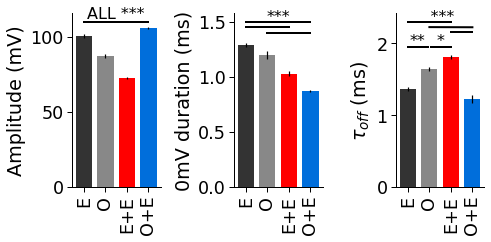

In [28]:
# plot AP metrics - [mean ap, std ap, mean 0mv duration, std 0mv duration, mean off tau, std off tau]
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(2 * GRID_SIZE, GRID_SIZE), sharex=True)
bar_palette = [ '#333333', '#888888', '#FF0000', costim_blue]

barsep = 2
barwidth = 1.5
ps = list(range(-2 * barsep, barsep * 4, barsep))

def draw_bar(ax, costim, ee, elec, opt, title, width=1, rotation=0):
    ax.bar(ps[0], elec['mean'], yerr=elec['sem'], color=bar_palette[0], width=width)
    ax.bar(ps[1], opt['mean'], yerr=opt['sem'], color=bar_palette[1], width=width)
    ax.bar(ps[2], ee['mean'], yerr=ee['sem'], color=bar_palette[2], width=width)
    ax.bar(ps[3], costim['mean'], yerr=costim['sem'], color=bar_palette[3], width=width)
    ax.set_xticks(ps)
    ax.set_xticklabels(('E', 'O', 'E+E', 'O+E'))
    
    if rotation != 0:
        for tick in ax.get_xticklabels():
            tick.set_rotation(rotation)
    
    ax.set_ylabel(title)

data = time_constant_df.reset_index()
costim = data[data['type'] == 'costim']
ee = data[data['type'] == 'all_elec']
esup = data[data['type'] == 'sup_e']
osup = data[data['type'] == 'sup_o']

# max membrane voltage plot
draw_bar(ax1, costim['amplitude'], ee['amplitude'], esup['amplitude'], osup['amplitude'], "Amplitude (mV)", rotation=90, width=barwidth)
draw_sig_points(ax1, [ps[0], 110], [ps[0], 110], [ps[3], 110], [ps[3], 110], 112, "ALL ***", fontsize=16)

# 0mV duration plot
draw_bar(ax2, costim['width'], ee['width'], esup['width'], osup['width'], "0mV duration (ms)", rotation=90, width=barwidth)
draw_sig_points(ax2, [ps[1], 1.35], [ps[1], 1.4], [ps[3], 1.4], [ps[3], 1.35], 1.4, "", fontsize=16)
draw_sig_points(ax2, [ps[0], 1.4], [ps[0], 1.45], [ps[2], 1.45], [ps[2], 1.4], 1.5, "", fontsize=16)
draw_sig_points(ax2, [ps[0], 1.45], [ps[0], 1.5], [ps[3], 1.5], [ps[3], 1.45], 1.5, "***", fontsize=16)


# off tau plot
draw_bar(ax3, costim['tau_off'], ee['tau_off'], esup['tau_off'], osup['tau_off'], "$\\tau_{off}$ (ms)", rotation=90, width=barwidth)    
draw_sig_points(ax3, [ps[0], 2.6], [ps[0], 2.3], [ps[2], 2.3], [ps[2], 2.6], 2.3, "     ***", fontsize=16)
draw_sig_points(ax3, [ps[1], 2.25], [ps[1], 2.222], [ps[3], 2.22], [ps[3], 2.25], 2.35, "", fontsize=16)
draw_sig_points(ax3, [ps[2], 1.92], [ps[2], 2.15], [ps[3], 2.15], [ps[3], 1.92], 2.02, "", fontsize=16)
draw_sig_points(ax3, [ps[0], 1.9], [ps[0], 1.95], [ps[1]-0.15, 1.95], [ps[1]-0.15, 1.9], 1.97, "**", fontsize=16)
draw_sig_points(ax3, [ps[1]+0.15, 1.9], [ps[1]+0.15, 1.95], [ps[2], 1.95], [ps[2], 1.9], 1.97, "*", fontsize=16)

sns.despine()

plt.tight_layout()
plt.show()

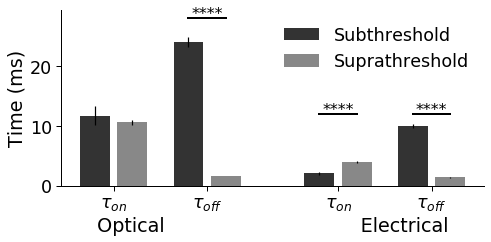

In [29]:
# now plot the results
fig, (ax) = plt.subplots(1, 1, figsize=(2*GRID_SIZE, GRID_SIZE))

p = []
ps = [0, 1, 2.5, 3.5, 6, 7, 8.5, 9.5]

ax.bar(ps[4], [time_constant_df['tau_on']['mean']['sub_e']], yerr=[time_constant_df['tau_on']['sem']['sub_e']], color=bar_palette[0], label='Subthreshold')
ax.bar(ps[6], [time_constant_df['tau_off']['mean']['sub_e']], yerr=[time_constant_df['tau_off']['sem']['sub_e']], color=bar_palette[0])

ax.bar(ps[0], [time_constant_df['tau_on']['mean']['sub_o']], yerr=[time_constant_df['tau_on']['sem']['sub_o']], color=bar_palette[0])
ax.bar(ps[2], [time_constant_df['tau_off']['mean']['sub_o']], yerr=[time_constant_df['tau_off']['sem']['sub_o']], color=bar_palette[0])

ax.bar(ps[5], [time_constant_df['tau_on']['mean']['sup_e']], yerr=[time_constant_df['tau_on']['sem']['sup_e']], color=bar_palette[1], label='Suprathreshold')
ax.bar(ps[7], [time_constant_df['tau_off']['mean']['sup_e']], yerr=[time_constant_df['tau_off']['sem']['sup_e']], color=bar_palette[1])

ax.bar(ps[1], [time_constant_df['tau_on']['mean']['sup_o']], yerr=[time_constant_df['tau_on']['sem']['sup_o']], color=bar_palette[1])
ax.bar(ps[3], [time_constant_df['tau_off']['mean']['sup_o']], yerr=[time_constant_df['tau_off']['sem']['sup_o']], color=bar_palette[1])

ax.set_xticks([0.5, 3, 6.5, 9])
ax.set_xticklabels(('$\\tau_{on}$', '$\\tau_{off}$', '$\\tau_{on}$', '$\\tau_{off}$'))

ax.set_xlabel('Optical                                Electrical')
ax.set_ylabel('Time (ms)')

draw_sig_points(ax, [ps[2], 27.2], [ps[2], 28], [ps[3], 28], [ps[3], 27.2 ], 28, "****", fontsize=16)
draw_sig_points(ax, [ps[4], 11.2 ], [ps[4], 12 ], [ps[5], 12 ], [ps[5], 11.2 ], 12, "****", fontsize=16)
draw_sig_points(ax, [ps[6], 11.2], [ps[6], 12], [ps[7], 12], [ps[7], 11.2 ], 12, "****", fontsize=16)

plt.legend(frameon=False)
sns.despine()
plt.tight_layout()
plt.show()

In [30]:
# plot comparison of dv/dts
height = 8

# statistical significance
# this excludes where dvdt is 0, which indicates no peak was found by the algorithm. This occurred for a few optical pulses
print("AVERAGE DV/DT BY TYPE")
valid_dvdt_df = time_constant_raw_df[time_constant_raw_df['dvdt_avg'] != 0]

by_type = lambda t: valid_dvdt_df[valid_dvdt_df['type'] == t]

oneway_anova('dvdt_avg', by_type('costim'), by_type('sup_e'), by_type('sup_o'), by_type('all_elec'))

print("\n\nAverage dV/dt:")
dvdt_avg_df = valid_dvdt_df.groupby(['type']).agg([np.mean, stats.sem])['dvdt_avg']
dvdt_avg_df

AVERAGE DV/DT BY TYPE


*** ANOVA (dvdt_avg) ***
One way ANOVA f: 93.23, p: 0.0000
 Multiple Comparison of Means - Tukey HSD, FWER=0.05  
group1 group2 meandiff p-adj   lower    upper   reject
------------------------------------------------------
costim    e+e  -28.422  0.001 -33.9577 -22.8862   True
costim   elec  -3.1917 0.6011  -9.9286   3.5451  False
costim    opt  11.8298  0.001   5.3396  18.3201   True
   e+e   elec  25.2302  0.001  18.1481  32.3124   True
   e+e    opt  40.2518  0.001  33.4038  47.0999   True
  elec    opt  15.0216  0.001   7.1707  22.8725   True
------------------------------------------------------
p-values: [0.001      0.60112863 0.001      0.001      0.001      0.001     ]


Average dV/dt:


,mean,sem
type,,
all_elec,46.912253,0.749333
costim,75.334236,1.790520
sup_e,72.142487,2.688510
sup_o,87.164084,1.375680


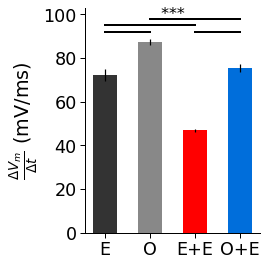

In [31]:
ps = [-2, -0.5, 1, 2.5]
height=11

fig, (ax) = plt.subplots(1, 1, figsize=(1.1*GRID_SIZE, 1.1*GRID_SIZE)) # non standard size to fit category labels
ax.bar([ps[0]], [dvdt_avg_df['mean']['sup_e']], yerr=[dvdt_avg_df['sem']['sup_e']], color=bar_palette[0])
ax.bar([ps[1]], [dvdt_avg_df['mean']['sup_o']], yerr=[dvdt_avg_df['sem']['sup_o']], color=bar_palette[1])
ax.bar([ps[2]], [dvdt_avg_df['mean']['all_elec']], yerr=[dvdt_avg_df['sem']['all_elec']], color=bar_palette[2])
ax.bar([ps[3]], [dvdt_avg_df['mean']['costim']], yerr=[dvdt_avg_df['sem']['costim']], color=bar_palette[3])

b1 = 98
b2 = b1+40
b3 = b2+40
draw_sig_points(ax, [ps[3], b1-3], [ps[3], b1], [ps[1], b1], [ps[1], b1-3], b1, "", fontsize=16)
draw_sig_points(ax, [ps[3], b1-3], [ps[3], b1-6], [ps[2], b1-6], [ps[2], b1-3], b1, "", fontsize=16)
draw_sig_points(ax, [ps[0], b1-3], [ps[0], b1-6], [ps[1], b1-6], [ps[1], b1-3], b1, "", fontsize=16)
draw_sig_points(ax, [ps[0], b2-3], [ps[0], b1-3], [ps[2], b1-3], [ps[2], b2-3], b1, "         ***", fontsize=16)

ax.set_xticks(ps)
ax.set_xticklabels(('E', 'O', 'E+E', 'O+E'))
ax.set_ylabel('$\\frac{\Delta V_m}{\Delta t}$ (mV/ms)')

# plt.legend(frameon=False)
sns.despine()
plt.tight_layout()
plt.show()

### Plot mean firing rates

[(40, 40), (40, 50), (40, 70), (40, 80), (45, 80), (45, 100), (60, 60), (60, 70), (60, 80), (65, 70), (70, 80), (80, 90)]


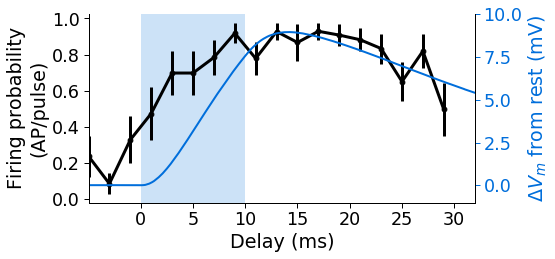

In [32]:
# this is the (opt, elec) power levels where 50% of APs are fired across all offsets
print(above_threshold_parameters)

times = np.array(range(0, 20500)) * (1000. / 50000.) - 100

spike_df_above50 = spike_df.copy()
spike_df_above50['above50'] = pd.Series(
    map(
        lambda o, e: (o, e) in above_threshold_parameters,
        spike_df_above50['Optical'],
        spike_df_above50['Electrical']
    ))

spike_df_above50_metrics = spike_df_above50[
    (spike_df_above50['above50'] == True) & 
    (spike_df_above50['Offset'] % 2 == 1)
].groupby(['Offset'])['Costim'].agg([np.mean, stats.sem]).dropna().reset_index()

fig, (ax1) = plt.subplots(1, 1, figsize=(2 * GRID_SIZE, GRID_SIZE))

# plot ALL values where any caused an AP (i.e. includes runs where only 1 AP was generated)
ax1.errorbar(
    spike_df_above50_metrics['Offset'],
    spike_df_above50_metrics['mean'] / 100.,
    yerr=spike_df_above50_metrics['sem'] / 100.,
    color='k', lw=3, marker='o'
)

ax1.axvspan(0, 10, -1, 1.1, facecolor=costim_blue, alpha=0.2)

ax2 = ax1.twinx()
ax2.plot(times[:18000], mean_optical - mean_optical[0], color=costim_blue, lw=2, zorder=1)

# sns.despine()
sns.despine(right=False)
ax2.set_ylabel("$\Delta V_m$ from rest (mV)")
ax2.yaxis.label.set_color(costim_blue)
ax2.tick_params(axis='y', colors=costim_blue, zorder=2)
ax2.set_ylim((-1, 10))


ax1.set_xlim((-5, 32))
ax1.set_xticks([0, 5, 10, 15, 20, 25, 30])
ax1.set_yticks([x / 5. for x in range(0, 6)])
ax1.set_xlabel("Delay (ms)")
ax1.set_ylabel("Firing probability\n(AP/pulse)")
plt.show()

In [33]:
OPT_ONSET_IDX = 5000 # int(100 * MS_TO_SAMPLES)

prob = np.array(spike_df_above50_metrics['mean'])

opt_curve = np.array([mean_optical[OPT_ONSET_IDX + int(i * MS_TO_SAMPLES)] for i in list(spike_df_above50_metrics['Offset'])])
# opt_curve = (opt_curve - opt_curve[0])

corr = stats.pearsonr(prob, opt_curve)
print(f"** Pearson's Cross-Correlation is {corr[0]:.2f} with p = {corr[1]:.4f}")

** Pearson's Cross-Correlation is 0.85 with p = 0.0000


In [34]:
dvdt_opt_mean = [0] + (mean_optical[1:]-mean_optical[:-1])
dvdt_opt_curve = [dvdt_opt_mean[int(5000 + x * MS_TO_SAMPLES)] for x in list(spike_df_above50_metrics['Offset'])]

corr = stats.pearsonr(prob, dvdt_opt_curve)
print(f"** Pearson's Cross-Correlation for all dv/dt is {corr[0]:.2f} with p = {corr[1]:.4f}")

corr = stats.pearsonr(prob[:6], dvdt_opt_curve[:6])
print(f"** Pearson's Cross-Correlation for first 10ms dv/dt is {corr[0]:.2f} with p = {corr[1]:.4f}")

# fig, (ax) = plt.subplots(1, 1)
# ax.plot(dvdt_opt_curve, marker='.')
# ax2 = ax.twinx()
# ax2.plot(prob)

** Pearson's Cross-Correlation for all dv/dt is 0.11 with p = 0.6613
** Pearson's Cross-Correlation for first 10ms dv/dt is 0.94 with p = 0.0061


In [35]:
# Apply multiple linear regression to dvdt / Vm --> firing probability

clf = LinearRegression()
reg_input = [[v, dv] for (v, dv) in zip(opt_curve, dvdt_opt_curve)]
clf.fit(reg_input, prob)

print(f"{clf.intercept_:.2f} + {clf.coef_[0]:.2f} * V + {clf.coef_[1]:.2f} * dvdt")
pred = clf.predict(reg_input)

corr = stats.pearsonr(prob, pred)
print(f"** Pearson's Cross-Correlation for multiple linear regression {corr[0]:.2f} with p = {corr[1]:.4f}")

535.98 + 6.93 * V + 962.31 * dvdt
** Pearson's Cross-Correlation for multiple linear regression 0.91 with p = 0.0000


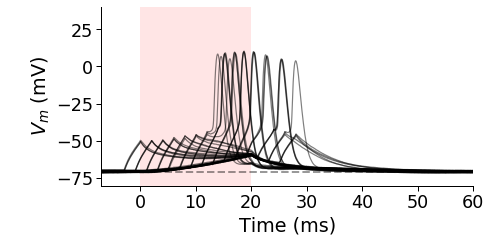

In [36]:
# fake electrical
fake_axo = axographio.read(os.path.join(d.BASE_PATH, FAKE_COSTIM_FILES[0][0]))

fig, (ax1) = plt.subplots(1, 1, figsize=(2 * GRID_SIZE, GRID_SIZE))
max_idx = (len(fake_axo.names) - 1)
stride = 1

# ax1.fill([0, 20, 20, 0], [20, 20, 21.5, 21.5], color='r')
ax1.axvspan(0, 20, -3, 50, facecolor='r', alpha=0.1)
ax1.axhline(-71, linestyle='--', color='k', alpha=0.4, lw=2)

for i in range(1, max_idx, 3 * stride):
    ax1.plot([x * SAMPLES_TO_MS - 500 for x in range(len(fake_axo.data[i]))], [(x + d.JNC_POT) * 1000 for x in fake_axo.data[i]], color='k', alpha=0.5)
    ax1.set_ylim((-80, 40))
    ax1.set_xlim((-7, 3000 * SAMPLES_TO_MS))

ax1.set_xlabel("Time (ms)")
ax1.set_ylabel("\n$V_m$ (mV)")

sns.despine()

plt.tight_layout()
plt.show()

In [37]:
# plot the mean "faked" optical response
elec_responses = np.zeros(90000)
num_elec_runs = 0

for fake in FAKE_COSTIM_FILES:
    fake_axo = axographio.read(os.path.join(d.BASE_PATH, fake[0]))
    max_idx = (len(fake_axo.names) - 1)
    
    # do a fairly budget average by just adding them all together and then dividing by count
    # slow but "easy"
    for i in range(1, max_idx, 3):
        elec_responses = elec_responses + fake_axo.data[i]
        num_elec_runs += 1

elec_response_mean = [(x) * (1000. / num_elec_runs) + (d.JNC_POT * 1000) for x in elec_responses]
elec_responses = None

In [38]:
fake_axos = []
fake_runs = []
for x in FAKE_COSTIM_FILES:
    path = os.path.join(d.BASE_PATH, x[0])
    fake_axos.append((axographio.read(path), x[1]))
    
# divide by 9 for 3 recording channels and 3 repetitions
get_num_offsets = lambda x: (len(x.data) - 1) // (3 * 3)
max_offset_count = np.max([get_num_offsets(x[0]) for x in fake_axos])
offsets = list(range(-3, -3 + max_offset_count * 2, 2))
spike_count = dict(zip(offsets, [0] * len(offsets)))
run_count = dict(zip(offsets, [0] * len(offsets)))
espike_perc = dict(zip(offsets, [0] * len(offsets)))

for axo, cell in fake_axos:
    num_offsets = get_num_offsets(axo)
    axo_offsets = offsets[:num_offsets]
    num_aps = 0
    offset_aps = []
    offset_runs = []
    
    for rep in range(3): # for each repetition
        for i, off in enumerate(axo_offsets): # for each offset
#             run_count[off] += 1 # add a run
            offset_runs.append(off)
            dat = axo.data[1 + 3 * rep * num_offsets + i * 3] # check if the run had APs
            
            pk_val = np.max(dat)
            if pk_val > 0 - d.JNC_POT:
#                 spike_count[off] += 1
                num_aps += 1
                offset_aps.append(off)
          
    # check if the axo file was above costim threshold, i.e. 50% of pulses fired APs
    perc_aps = num_aps / float(len(axo_offsets))
    if perc_aps >= 0.5:
        # above threshold, add the run and offset count
        for off in offset_aps:
            spike_count[off] += 1
        for off in offset_runs:
            run_count[off] += 1

for offset in offsets:
    espike_perc[offset] = 0 if run_count[offset] == 0 else round(100. * spike_count[offset] / run_count[offset])

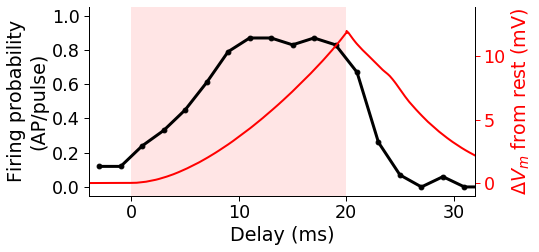

In [39]:
fig, (ax1) = plt.subplots(1, 1, figsize=(2 * GRID_SIZE, GRID_SIZE))
# plot ALL values where any caused an AP (i.e. includes runs where only 1 AP was generated)
ax1.plot(list(espike_perc.keys()), [x / 100. for x in espike_perc.values()], color='k', lw=3, marker='o')

ax2 = ax1.twinx()
elec_times = [x * SAMPLES_TO_MS - (1000 * SAMPLES_TO_MS) for x in range(18000)]
ax2.plot(elec_times, elec_response_mean[49000:67000] - elec_response_mean[49000], color='r', lw=2)

# ax1.fill([0, 20, 20, 0], [1, 1, 0.99, 0.99], color='r')
ax1.axvspan(0, 20, -10, 10, facecolor='r', alpha=0.1)

sns.despine(right=False)

ax2.set_ylabel("$\Delta V_m$ from rest (mV)")
ax1.set_yticks([x / 5. for x in range(0, 6)])
ax1.set_xlabel("Delay (ms)")
ax1.set_ylabel("Firing probability\n(AP/pulse)")

ax2.yaxis.label.set_color('r')
ax2.tick_params(axis='y', colors='r', zorder=2)

ax1.set_xlim((-4, 32))
ax3.set_xlim((-4, 32))
ax3.set_ylim((-0.3, 1.3))
ax1.set_ylim((-0.05, 1.05))
ax2.set_ylim((-1, 13.9))

plt.show()

In [40]:
# Correlation of mock firing rate with average mock response 
espike_perc_vals = list(espike_perc.values())
elec_curve = np.array([elec_response_mean[49000:67000][int(2 * i * MS_TO_SAMPLES)] for i in range(-3, 36, 2)])

corr = stats.pearsonr(espike_perc_vals, elec_curve)
print(f"** Pearson's Cross-Correlation with elec curve is {corr[0]:.2f} with p = {corr[1]:.3f}")

** Pearson's Cross-Correlation with elec curve is 0.44 with p = 0.051


In [41]:
# Correlation of mock firing rate with derivative of average mock response 
espike_perc_vals = list(espike_perc.values())
dvdt_mock = [0] + np.diff(elec_response_mean[49000:67000])
elec_curve_dvdt = np.array([dvdt_mock[int(2 * i * MS_TO_SAMPLES)] for i in range(-3, 36, 2)])

pts_to_check = 12
avg_period_for_dvdt = 30

def get_mock_xy(data, pts):
    x = [i for i in range(-3, 36, 2)][:pts]
    return (
        x,
        [np.mean(
                data[
                    int((idx + 20) * MS_TO_SAMPLES) - avg_period_for_dvdt : 
                    int((idx + 20) * MS_TO_SAMPLES) + avg_period_for_dvdt
                ]) for idx in x],
        [stats.sem(
                data[
                    int((idx + 20) * MS_TO_SAMPLES) - avg_period_for_dvdt : 
                    int((idx + 20) * MS_TO_SAMPLES) + avg_period_for_dvdt
                ]) for idx in x])

x, y, _ = get_mock_xy(dvdt_mock, pts_to_check)

corr = stats.pearsonr(espike_perc_vals[:pts_to_check], elec_curve_dvdt[:pts_to_check])
print(f"** Pearson's Cross-Correlation with first {pts_to_check} points of dv/dt for elec curve is {corr[0]:.2f} with p = {corr[1]:.3f}")

** Pearson's Cross-Correlation with first 12 points of dv/dt for elec curve is 0.66 with p = 0.018


In [42]:
corr3 = stats.pearsonr(espike_perc_vals, elec_curve_dvdt)
print(f"** Pearson's Cross-Correlation with ALL dv/dt for elec curve is {corr3[0]:.2f} with p = {corr3[1]:.3f}")

** Pearson's Cross-Correlation with ALL dv/dt for elec curve is 0.55 with p = 0.013


In [43]:
# Apply multiple linear regression to dvdt / Vm --> firing probability

clf = LinearRegression()
reg_input = [[v, dv] for (v, dv) in zip(elec_curve, elec_curve_dvdt)]
clf.fit(reg_input, espike_perc_vals)

print(f"{clf.intercept_:.2f} + {clf.coef_[0]:.2f} * V + {clf.coef_[1]:.2f} * dvdt")
pred = clf.predict(reg_input)

corr = stats.pearsonr(espike_perc_vals, pred)
print(f"** Pearson's Cross-Correlation for multiple linear regression {corr[0]:.2f} with p = {corr[1]:.4f}")

344.46 + 4.46 * V + 2073.33 * dvdt
** Pearson's Cross-Correlation for multiple linear regression 0.70 with p = 0.0006


## Na Inactivation Lines

D:\Tools\Anaconda\lib\site-packages\numpy\core\_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
D:\Tools\Anaconda\lib\site-packages\numpy\core\_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


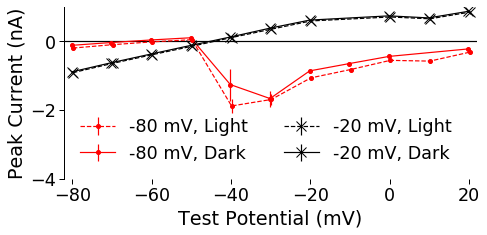

In [44]:
# calculate time points:

ms100 = int(0.1 * 1000 * MS_TO_SAMPLES) # samples in 100ms

# timing for conditioning pulse
condition0 = int(0.25 * 1000 * MS_TO_SAMPLES)
condition1 = condition0 + ms100

# timing for steady state test pulse
test0 = int(0.58 * 1000 * MS_TO_SAMPLES)
test1 = test0 + ms100

# # inwards part of the response
testii0 = int(400.2 * MS_TO_SAMPLES)
testii1 = testii0 + int(2 * MS_TO_SAMPLES)

results = []
for idx, f in enumerate(VC_INACTIVATION_FILES):
    axo = axographio.read(os.path.join(d.BASE_PATH, f[0]))

    for start_idx in range(1, len(axo.names) - 1, 3):
        i_idx = start_idx
        v_idx = i_idx + 2
        
        # get the averages from the data
        hold_v = np.mean(axo.data[v_idx][0:ms100])
        cond_v = np.mean(axo.data[v_idx][condition0:condition1]) - hold_v
        ss_v = np.mean(axo.data[v_idx][test0:test1]) # - hold_v
        ss_i = np.mean(axo.data[i_idx][test0:test1])
        ii_i = np.min(axo.data[i_idx][testii0:testii1])
        
        # convert to pA and mV and round to nearest 10
        hold_v = round((hold_v * 1000) * 10) / 1
        cond_v = round((cond_v * 1000) / 10) * 10
        ss_v = round((ss_v * 1000) / 10) * 10
        ss_i = float((ss_i * q.A).rescale('nA').magnitude)
        ii_i = float((ii_i * q.A).rescale('nA').magnitude)
                
        results.append({
            "hold_v": hold_v,
            "file_idx": idx, 
            "conditioning_v": cond_v,
            "test_steady_state_v": ss_v,
            "test_steady_state_i": ss_i,
            "test_init_inward_i": ii_i,
            "cell": f[1],
            "type": f[2]
        })

df = pd.DataFrame(results)
sorted(np.unique(df['conditioning_v']))

agg_ss = df[df['conditioning_v'] >= -40]\
    .groupby(['conditioning_v', 'test_steady_state_v', 'type'])\
    .agg([np.mean, stats.sem, 'count'])['test_steady_state_i']\
    .fillna(0)\
    .reset_index()
# agg_ss.head()

agg_ii = df[df['conditioning_v'] >= -40]\
    .groupby(['conditioning_v', 'test_steady_state_v', 'type'])\
    .agg([np.mean, stats.sem, 'count'])['test_init_inward_i']\
    .fillna(0)\
    .reset_index()
agg_ii.head()


cv = 'conditioning_v'
tv = 'test_steady_state_v'
conditioning = [-20, 40]

fig, ax = plt.subplots(1, 1, figsize=(2 * GRID_SIZE, GRID_SIZE))

l_n_40 = agg_ii[(agg_ii['type'] == 'Laser') & (agg_ii[cv] == conditioning[0]) & (agg_ii[tv] >= -80)]
l_40 = agg_ii[(agg_ii['type'] == 'Laser') & (agg_ii[cv] == conditioning[1]) & (agg_ii[tv] >= -80)]

nl_n_40 = agg_ii[(agg_ii['type'] == 'No Laser') & (agg_ii[cv] == conditioning[0]) & (agg_ii[tv] >= -80)]
nl_40 = agg_ii[(agg_ii['type'] == 'No Laser') & (agg_ii[cv] == conditioning[1]) & (agg_ii[tv] >= -80)]

plt.axhline(0, color='k')

ax.errorbar(l_n_40[tv]+0.15, l_n_40['mean'], yerr=l_n_40['sem'], linestyle='--', color='r', marker='.', markersize=8, label=f'{conditioning[0] - 60} mV, Light')
ax.errorbar(nl_n_40[tv]-0.15, nl_n_40['mean'], yerr=nl_n_40['sem'], marker='.', color='r', markersize=8, label=f'{conditioning[0] - 60} mV, Dark')

ax.errorbar(l_40[tv]+0.15, l_40['mean'], yerr=l_40['sem'], linestyle='--', color='k', marker='x', markersize=10, label=f'{conditioning[1] - 60} mV, Light')
ax.errorbar(nl_40[tv]-0.15, nl_40['mean'], yerr=nl_40['sem'], marker='x', markersize=10, color='k', label=f'{conditioning[1] - 60} mV, Dark')

sns.despine(bottom=True)
plt.legend(ncol=2, frameon=False)
plt.xlabel('Test Potential (mV)')
plt.ylabel('Peak Current (nA)')
plt.xlim((-82,22))
plt.ylim((-4, 1))

plt.tight_layout()

In [45]:
ks_results = {}

ks_results[conditioning[0]] = {
    "all": stats.ks_2samp(l_n_40['mean'], nl_n_40['mean']),
    "pre10": stats.ks_2samp(l_n_40[l_n_40[tv] < 10]['mean'], nl_n_40[nl_n_40[tv] < 10]['mean']),
    "post10": stats.ks_2samp(l_n_40[l_n_40[tv] >= 10]['mean'], nl_n_40[nl_n_40[tv] >= 10]['mean']),
}

ks_results[conditioning[1]] = {
    "all": stats.ks_2samp(l_40['mean'], nl_40['mean']),
    "pre10": stats.ks_2samp(l_40[l_40[tv] < 10]['mean'], nl_40[nl_40[tv] < 10]['mean']),
    "post10": stats.ks_2samp(l_40[l_40[tv] >= 10]['mean'], nl_40[nl_40[tv] >= 10]['mean']),
}

c0 = conditioning[0]
c1 = conditioning[1]

# ks_results
print(f"Comparison of laser on / off at {c0-60} mV - score {ks_results[c0]['all'].statistic:.2f}, p={ks_results[c0]['all'].pvalue:.2f}")
print(f"Comparison of laser on / off at {c1-60} mV - score {ks_results[c1]['all'].statistic:.2f}, p={ks_results[c1]['all'].pvalue:.2f}")

Comparison of laser on / off at -80 mV - score 0.18, p=0.99
Comparison of laser on / off at -20 mV - score 0.10, p=1.00


## dv/dt threshold

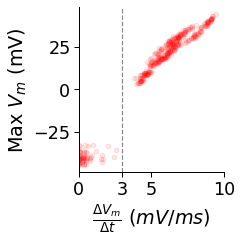

In [46]:
dvdt_pairs = []
dvdt_pairs_alternate = []

ten_ms = int(10 * MS_TO_SAMPLES)

for f in DVDT_FILES:
    axo = axographio.read(os.path.join(d.BASE_PATH, f[0]))
    ramp_lengths = list(range(f[2], f[2] + f[3] * f[4], f[4]))
    
    for idx, mv_idx in enumerate(range(1, len(axo.names), 2)):
        data = axo.data[mv_idx][4000:]

        (peaks, _) = find_peaks(data, distance=1000, height=0.003)
        
        # if no peaks found, get the average gradient across the whole ramp to the end of the ramp
        if len(peaks) == 0:
            ramp_length = ramp_lengths[idx % len(ramp_lengths)] # in ms
            ramp_samples = int(MS_TO_SAMPLES * ramp_length) # ramp length in samples
            
            # NOTE1: The ramp starts on the 5,000th sample, but we exclude the first 4,000 above.
            max_val = data[1000 + ramp_samples] 
            init = np.mean(axo.data[mv_idx][0:100]) # mean of first 100 samples as baseline
            delta = 1000 * (max_val - init)  # delta in mV
            
            max_idx = np.argmax(data)
            
            dvdt = (delta) / (SAMPLES_TO_MS * (max_idx - 5000)) # average gradient across the ramp in mV/ms

            dvdt_pairs.append((dvdt, data[max_idx] * 1000)) # peak is the maximum value
            dvdt_pairs_alternate.append((dvdt, data[max_idx] * 1000)) # peak is the maximum value
            continue
            
        # if we have peaks, loop through each one and find the 
        # average gradient over the 10ms before the peak started
        widths = peak_widths(data, peaks, rel_height=0.1)[2]
        for (peak, width) in zip(peaks, widths):
            # gradient in the 10ms before the start
            peak_start = int(width)
            start = data[peak_start - ten_ms]
            end = data[peak_start]
            delta = 1000 * (end - start)
            dvdt = delta / 10 # gradient in mV/ms            
            dvdt_pairs.append((dvdt, data[peak] * 1000))
            
            # gradient over the entire ramp up until the start of the peak
            # the first sample when the ramp is on. Actually 5000th in the data, see note1 above
            val_at_start = data[1000] 
            dvdt_pairs_alternate.append((1000*(end - val_at_start) / (SAMPLES_TO_MS * (peak_start - 5000)), data[peak] * 1000))

dvdt_pairs = list(zip(*dvdt_pairs))
dvdt_pairs_alternate = list(zip(*dvdt_pairs_alternate))

fig, ax1 = plt.subplots(1, 1, figsize=(GRID_SIZE, GRID_SIZE))
ax1.scatter(dvdt_pairs[0], dvdt_pairs[1], alpha=0.1, facecolor='r')
ax1.set_xlim((0, 10))

ax1.set_ylabel('Max $V_m$ (mV)')
ax1.set_xlabel('$\\frac{\Delta V_m}{\Delta t}$ ($mV/ms$)')

plt.axvline(3, color='#888888', linestyle='--')

plt.xticks([0, 3, 5, 10])

sns.despine()
plt.tight_layout()
plt.show()